In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
from src.utils import flatten_level_columns as flc
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

In [124]:
sns.color_palette('hsv', n_colors = 13)

[(1.0, 0.4169121816180639, 0.0),
 (1.0, 0.8338243632361279, 0.0),
 (0.7492634551458082, 1.0, 0.0),
 (0.309189485660074, 1.0, 0.0),
 (0.0, 1.0, 0.10772241105651532),
 (0.0, 1.0, 0.5246319661417559),
 (0.0, 1.0, 0.9647031631761764),
 (0.0, 0.6183848775760541, 1.0),
 (0.0, 0.201472695957991, 1.0),
 (0.2154394856600736, 0.0, 1.0),
 (0.6555134551458082, 0.0, 1.0),
 (1.0, 0.0, 0.9275743632361277),
 (1.0, 0.0, 0.5106621816180639)]

In [149]:
palette=sns.color_palette('hsv', n_colors = 13)
n4=[palette[x] for x in [0, 3, 8, -1]]
sns.color_palette(n4)

[(1.0, 0.4169121816180639, 0.0),
 (0.309189485660074, 1.0, 0.0),
 (0.0, 0.201472695957991, 1.0),
 (1.0, 0.0, 0.5106621816180639)]

In [152]:
palette=sns.color_palette('hsv', n_colors = 13)
n4=[palette[x] for x in [0, 3, 8, -1]]
sns.color_palette(n4)
n3=[palette[x] for x in [-5, -3, -1]]
sns.color_palette(n3)

[(0.0, 0.201472695957991, 1.0),
 (0.6555134551458082, 0.0, 1.0),
 (1.0, 0.0, 0.5106621816180639)]

# init

In [2]:
# Re-reading the various datasets 
COLUMNS=['Peptide', 'HLA', 'agg_label', 'total_count', 'percentage_pos']

df_cedar_posneg_hp = pd.read_csv('../data/cedar_posneg_hp.csv')
df_cedar_subsampled_negs = pd.read_csv('../data/cedar_subsampled_negs.csv')
df_all = pd.read_csv('../data/cedar_filtered.csv', usecols = COLUMNS)#.drop(columns=['Unnamed: 0'])
df_all['len'] = df_all.Peptide.apply(len)

df_refined = pd.concat([df_all.query('agg_label==1'), df_all.query('agg_label==0 and total_count > 1')])
df_hp_hobohm = pd.concat([df_all.query('agg_label==1'), 
                          pd.read_csv('../data/human_proteome_negs_n5_hobohm1_rs13', usecols=COLUMNS[:2])])
df_hp_hobohm['agg_label'].fillna(0, inplace=True)
df_hp_hobohm['total_count'].fillna(1, inplace=True)
df_hp_hobohm['percentage_pos'].fillna(0, inplace=True)
df_hp_hobohm['len']=df_hp_hobohm['Peptide'].apply(len)

In [3]:
# Re-reading the core alignment data from the NNalign outputs
DATADIR = '../data/'
NNDIR='../../../nnalign/output/'
cores=[os.path.join(os.path.join(NNDIR,x),z) for x in os.listdir(NNDIR) \
       for z in os.listdir(os.path.join(NNDIR,x)) if z.endswith('pred')]

core_cedar_posneg_hp = pd.read_csv('../../../nnalign/output/cedar_posneg_hp.pep_30041\\cedar_posneg_hp.pep_30041.lg6.sorted.pred', sep='\t')
core_cedar_subsampled_negs = pd.read_csv('../../../nnalign/output/cedar_subsampled_negs.pep_24820\\cedar_subsampled_negs.pep_24820.lg6.sorted.pred', 
                                         sep='\t')
core_cedar_all = pd.read_csv('../../../nnalign/output/dataset_all.pep_31000\\dataset_all.pep_31000.lg6.sorted.pred',
                             sep='\t')
core_cedar_refined = pd.read_csv('../../../nnalign/output/dataset_filtered.pep_32896\\dataset_filtered.pep_32896.lg6.sorted.pred'
                                 , sep='\t')
core_cedar_hp_hobohm = pd.read_csv('../../../nnalign/output/dataset_hp_hobohm.pep_34725\\dataset_hp_hobohm.pep_34725.lg6.sorted.pred'
                                   , sep='\t')

In [4]:
# Getting the best predicted HLA allele for the cedar dataset (used later for filtering in AUC vs HLA part)
from src.utils import flatten_level_columns, parse_netmhcpan_header, read_netmhcpan_results, query_melt_threshold, set_hla, return_columns, filter_rank, get_filtered_df
cedar_xls = read_netmhcpan_results('../data/cedar_filtered.xls')
cedar_xls = get_filtered_df(filter_rank(cedar_xls, 'EL_Rank'), cedar_xls)
cedar_all = pd.merge(left=df_all, right=cedar_xls.rename(columns={'HLA':'pred_HLA'}), left_index=True, right_index=True)
cedar_all['HLA']= cedar_all['HLA'].str.replace('*','')

In [5]:
# making a nice dict to house all my results
results = {}
keys=['cedar_subsampled_negs', 'cedar', 'cedar_refined', 'cedar_posneg_hp', 'cedar_hp_hobohm']
for key, df, core in zip(keys,
                         [df_cedar_subsampled_negs, df_all, df_refined, df_cedar_posneg_hp, df_hp_hobohm],
                         [core_cedar_subsampled_negs, core_cedar_all, core_cedar_refined, core_cedar_posneg_hp, core_cedar_hp_hobohm]):
    results[key] = {}
    core = pd.merge(df[['Peptide', 'HLA']], core, left_on='Peptide', right_on='Peptide')
    results[key]['df'] = df
    results[key]['core'] = core
    # quickly checking the datalength match
    print(key, len(df), len(core))

cedar_subsampled_negs 777 777
cedar 1687 1687
cedar_refined 777 777
cedar_posneg_hp 3738 3738
cedar_hp_hobohm 5173 5173


# AUCs etc

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve

## Dataset comparison

cedar_subsampled_negs
AUC:	0.54233
cedar
AUC:	0.61617
cedar_refined
AUC:	0.65354
cedar_posneg_hp
AUC:	0.6878
cedar_hp_hobohm
AUC:	0.78062


Text(0.5, 1.0, 'Dataset comparison for NNAlign prediction')

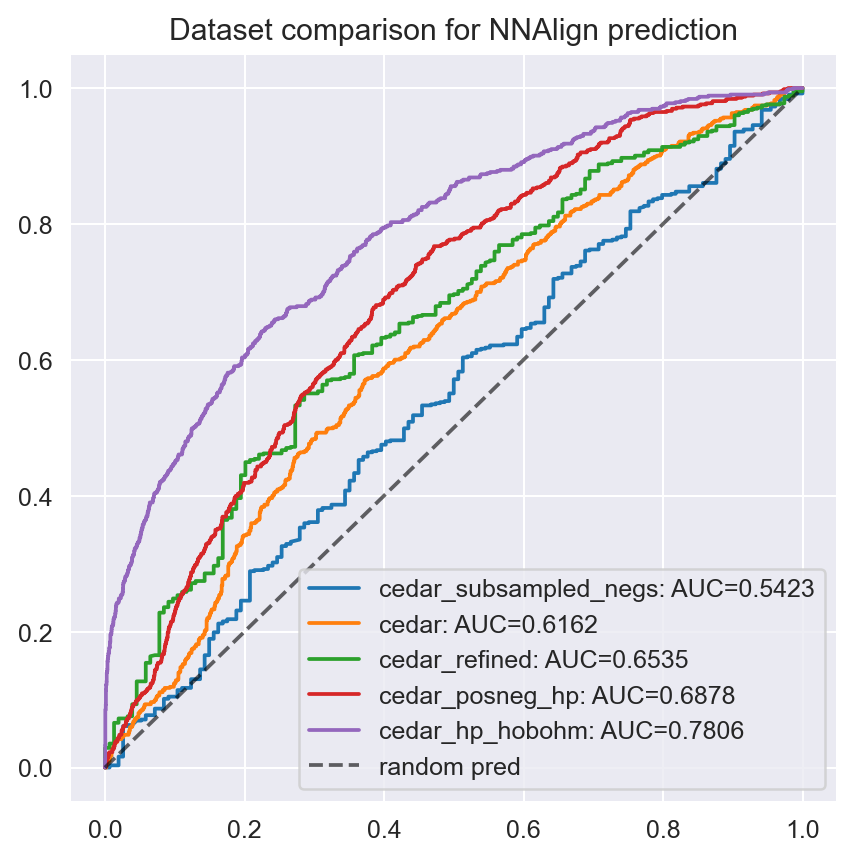

In [7]:
f,a = plt.subplots(1,1, figsize=(5.5,5.5))
for k in results.keys():
    y_true = results[k]['core']['Measure'].values.astype(int)
    y_score = results[k]['core']['Prediction'].values
    fpr,tpr,thresholds=roc_curve(y_true, y_score, pos_label=1.0)
    results[k]['fpr'] = fpr
    results[k]['tpr'] = tpr
    results[k]['auc'] = roc_auc_score(y_true, y_score)
    print(f'{k}\nAUC:\t{results[k]["auc"].round(5)}')
    sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={results[k]["auc"].round(4)}', estimator=None)
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6)
a.set_title('Dataset comparison for NNAlign prediction')

In [8]:
for k in results.keys():
    results[k]['core']['HLA'] = results[k]['core']['HLA'].apply(lambda x: x.replace('*',''))
    results[k]['core']['Measure'] = results[k]['core']['Measure'].astype(int)

## HLA comparison & using rank as scores

In [9]:
# re-getting the predicted HLA and rank values for the negative part of results['cedar_hp_hobohm']
scored9=pd.concat([pd.read_csv(f'../output/9mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored10=pd.concat([pd.read_csv(f'../output/10mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored= pd.concat([scored9, scored10])
hp_neg = results[k]['core'].query('Measure==0')
hp_neg_scored = hp_neg.merge(scored.drop(columns=['HLA']),
                             left_on = 'Peptide', right_on = 'Peptide')
del scored, scored9, scored10, hp_neg

# Next up I need to basically merge the hp_neg_scored, cedar_all (which is basically cedar_scored with the predicted & true HLA)
# and the core (results['cedar_hp_hobohm']['core']) so I can filter on the results.

hp_neg_scored.columns = hp_neg_scored.columns.str.replace('-','_').str.replace('Rank','rank')
hp_neg_scored['agg_label']=0
hp_neg_scored['percentage_pos']=0
hp_neg_scored['total_count']=1
hp_neg_scored['len']=hp_neg_scored['Peptide'].apply(len)
hp_neg_scored['pred_HLA']=hp_neg_scored['HLA']

df_cedar_hp_scored = pd.concat([cedar_all.query('agg_label==1'), hp_neg_scored[cedar_all.columns]])
df_cedar_hp_scored

cedar_hp_core = results[k]['core'].merge(df_cedar_hp_scored.drop(columns=['HLA', 'len']).rename(columns={'core':'netMHC_core'}),
                         left_on = 'Peptide', right_on = 'Peptide')


## Scores comparison

3294
1879
5173


Text(0.5, 0.98, 'Comparison of AUC for different scoring methods for HLA-A0201, NOT HLA-A0201, All')

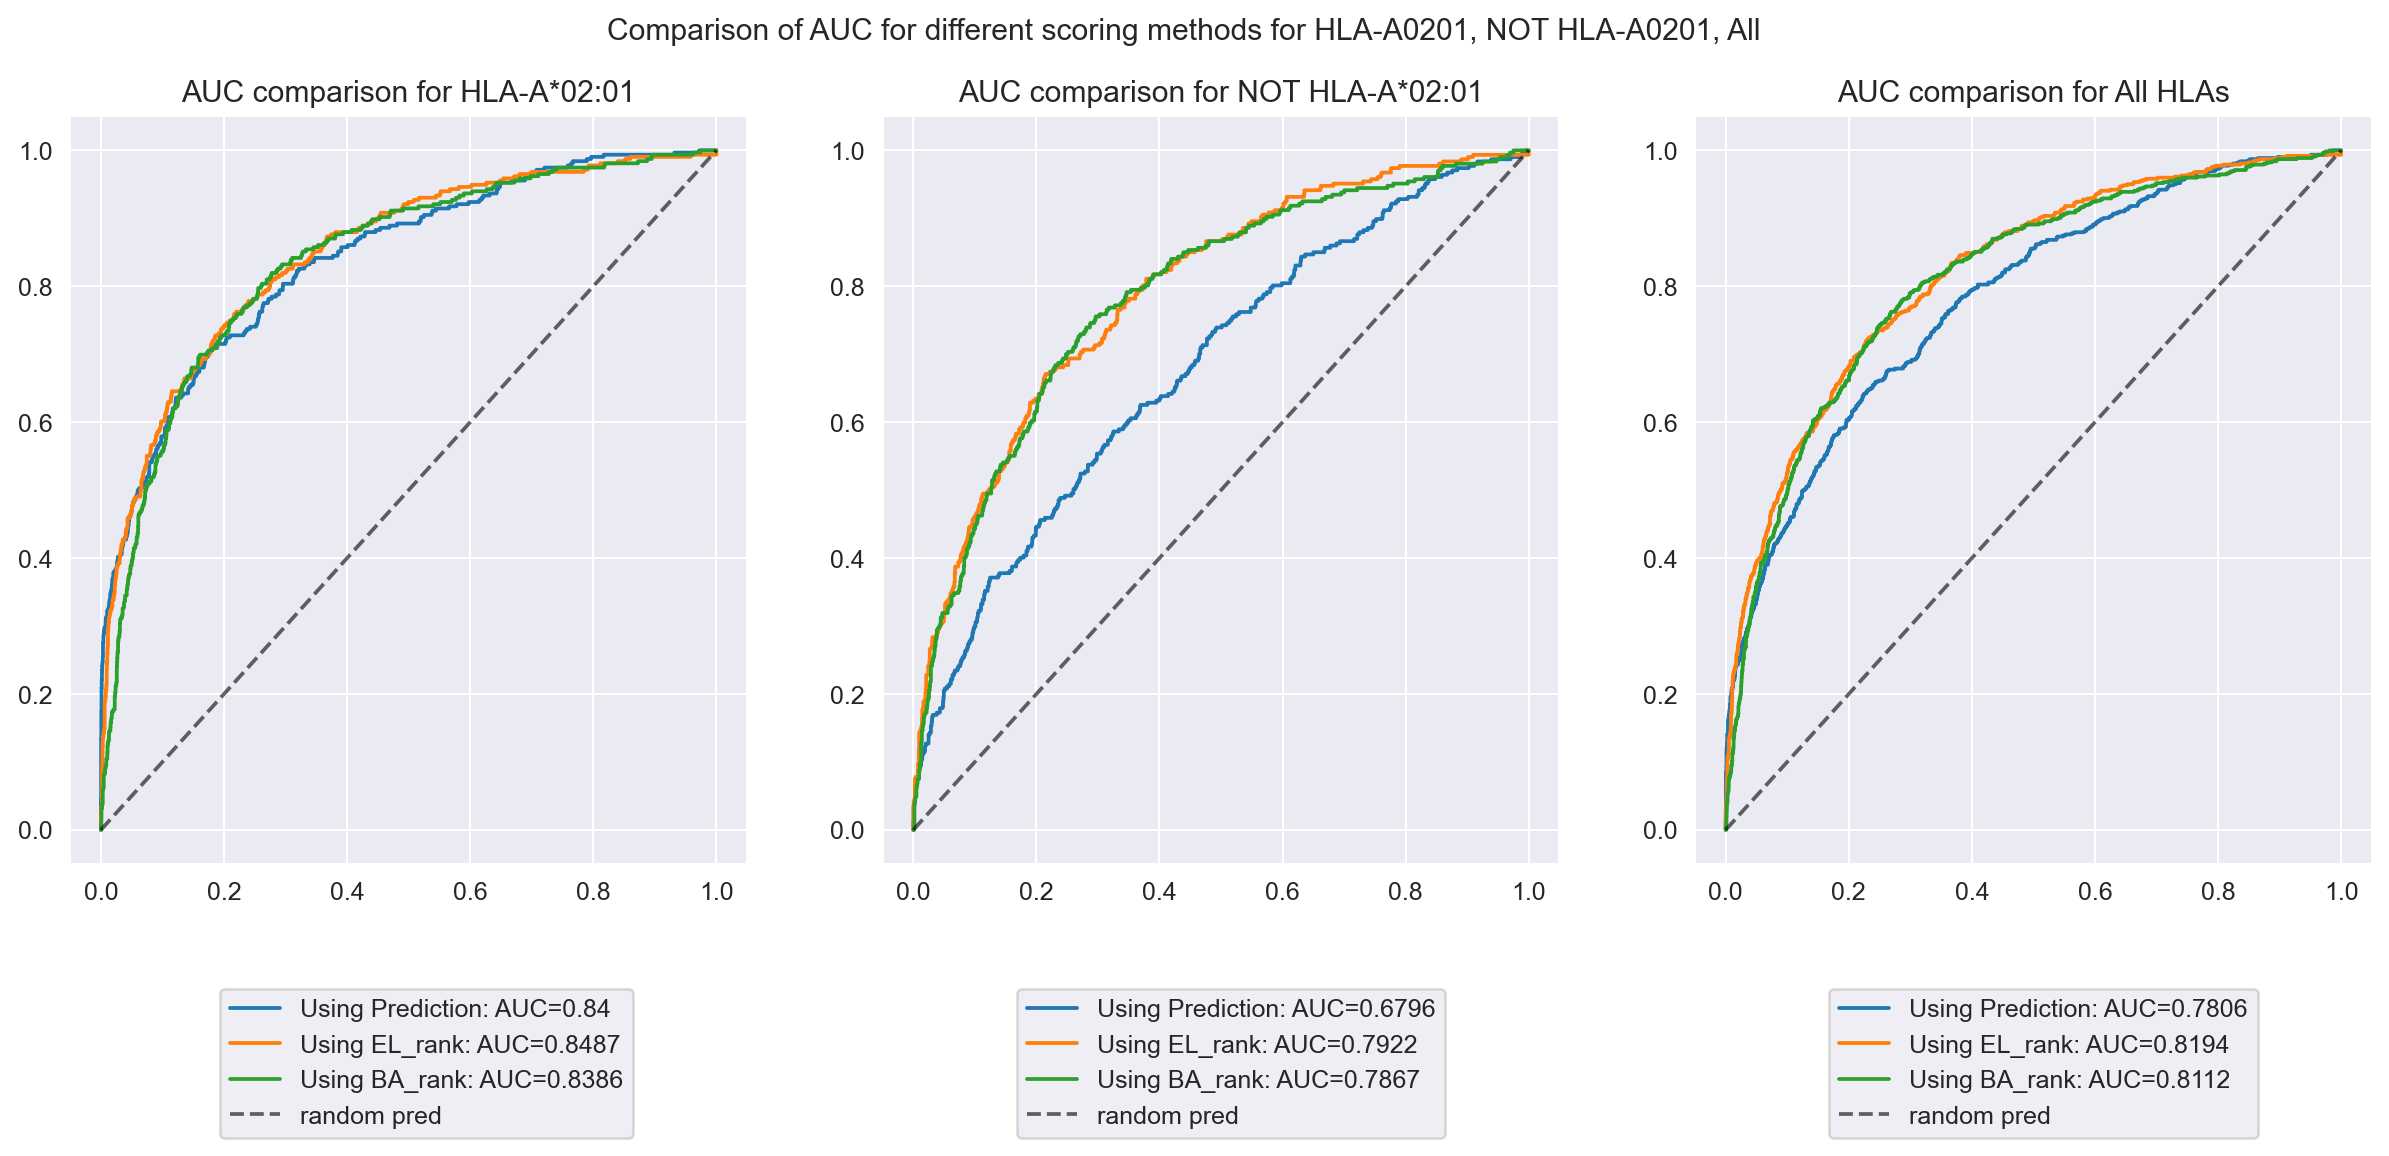

In [10]:
f,a = plt.subplots(1,3, figsize=(16.5, 5.5))

for top_hla, axis in zip(['a0201', 'no', 'all'], [0,1,2]):
    if top_hla=='a0201':
        tmp = cedar_hp_core.query('HLA=="HLA-A02:01"').copy()
        name = "HLA-A*02:01" 
    if top_hla=='no':
        tmp = cedar_hp_core.query('HLA!="HLA-A02:01"').copy()
        name = "NOT HLA-A*02:01"
    if top_hla=='all':
        tmp = cedar_hp_core.copy()
        name = "All HLAs"
    print(len(tmp))
    for scoring in ['Prediction', 'EL_rank', 'BA_rank']:
        sign = 1 if scoring=='Prediction' else -1
        y_true = tmp['agg_label'].values
        scores = tmp[scoring].values*sign
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)
        sns.lineplot(x=fpr, y=tpr, label = f'Using {scoring}: AUC={auc.round(4)}', ax = a[axis], estimator = None)
                
    sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[axis])
    a[axis].set_title(f'AUC comparison for {name}')
    a[axis].legend(bbox_to_anchor=(.85, -.15))
f.suptitle('Comparison of AUC for different scoring methods for HLA-A0201, NOT HLA-A0201, All')


## True HLA vs False

3294
1879
5173


Text(0.5, 0.98, 'Comparison of AUC for different scoring methods for HLA-A0201, NOT HLA-A0201, All\ndifferentiating predicted HLA from true HLA')

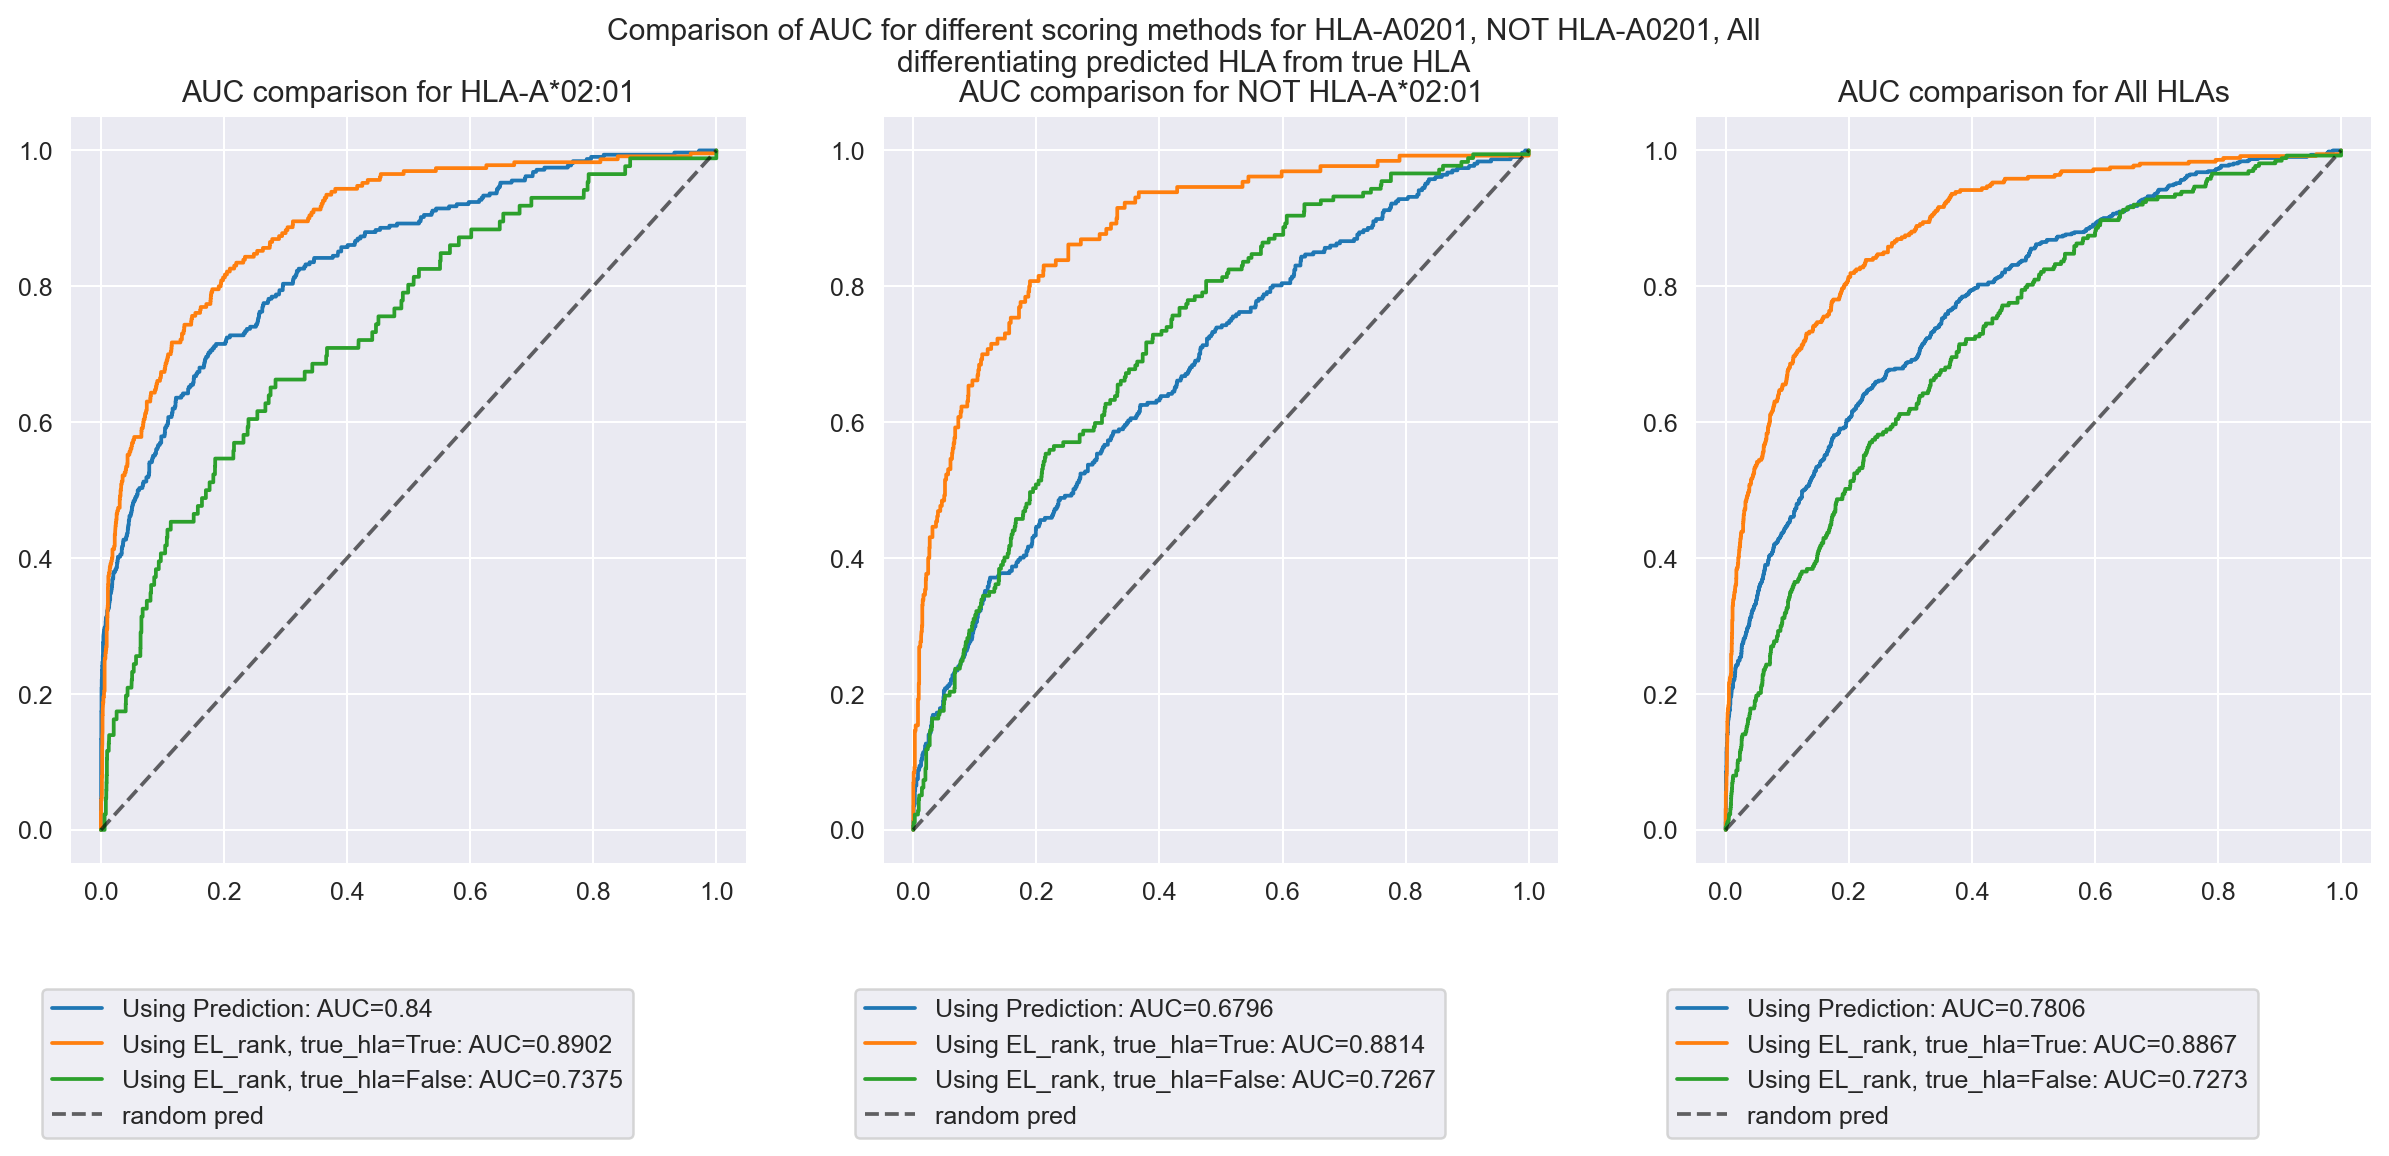

In [11]:
f,a = plt.subplots(1,3, figsize=(16.5, 5.5))

for top_hla, axis in zip(['a0201', 'no', 'all'], [0,1,2]):
    if top_hla=='a0201':
        tmp = cedar_hp_core.query('HLA=="HLA-A02:01"').copy()
        name = "HLA-A*02:01" 
    if top_hla=='no':
        tmp = cedar_hp_core.query('HLA!="HLA-A02:01"').copy()
        name = "NOT HLA-A*02:01"
    if top_hla=='all':
        tmp = cedar_hp_core.copy()
        name = "All HLAs"
    print(len(tmp))
    for scoring in ['Prediction', 'EL_rank']:
        sign = 1 if scoring=='Prediction' else -1
        if scoring == 'Prediction':
            y_true = tmp['agg_label'].values
            scores = tmp[scoring].values * sign
            fpr, tpr, _ = roc_curve(y_true, scores)
            auc = roc_auc_score(y_true, scores)
            sns.lineplot(x=fpr, y=tpr, label = f'Using {scoring}: AUC={auc.round(4)}', ax = a[axis], estimator = None)
        else:
            negs = tmp.query('agg_label==0')
            for true_hla in [True, False]:
                pos = tmp.query('agg_label==1')
                pos = pos.loc[pos['HLA']==pos['pred_HLA']] if true_hla else pos.loc[pos['HLA']!=pos['pred_HLA']]
                tmp_1 = pd.concat([pos, negs])
                y_true = tmp_1['agg_label'].values
                scores = tmp_1[scoring].values * sign
                fpr, tpr, _ = roc_curve(y_true, scores)
                auc = roc_auc_score(y_true, scores)
                sns.lineplot(x=fpr, y=tpr, label = f'Using {scoring}, true_hla={true_hla}: AUC={auc.round(4)}', ax = a[axis], estimator=None)
                
    sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[axis])
    a[axis].set_title(f'AUC comparison for {name}')
    a[axis].legend(bbox_to_anchor=(.85, -.15))
f.suptitle('Comparison of AUC for different scoring methods for HLA-A0201, NOT HLA-A0201, All\ndifferentiating predicted HLA from true HLA')


## Top 5 HLAs comparison using EL_rank

<AxesSubplot:title={'center':'Predicted HLA is NOT true HLA'}>

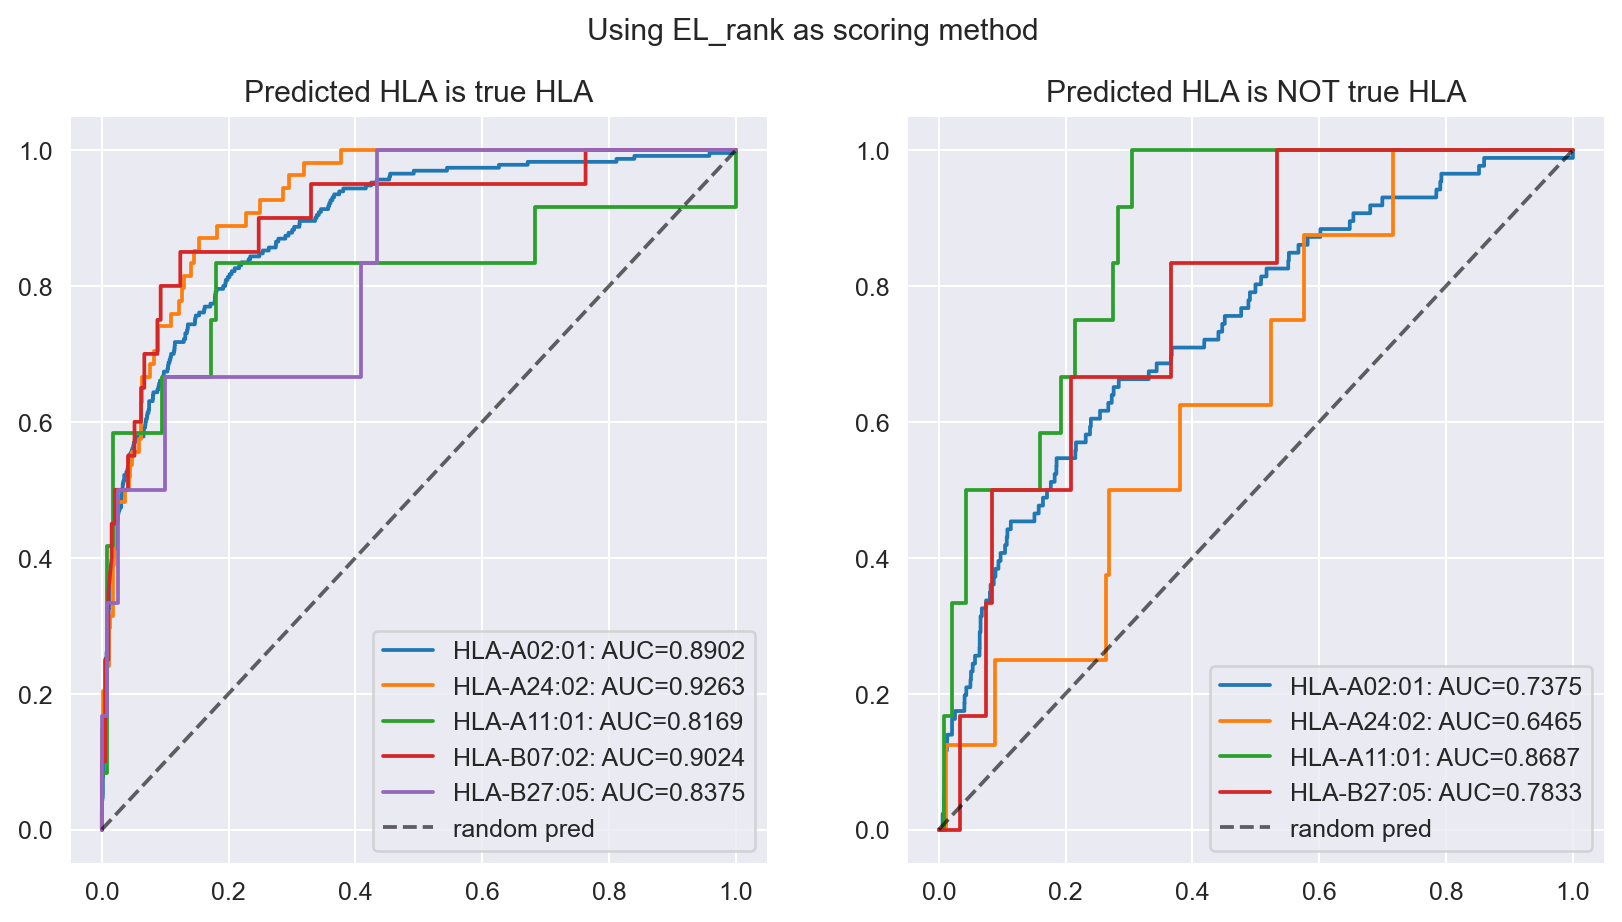

In [12]:
top10_hla = cedar_hp_core.groupby(['HLA'])[['Peptide']].count().sort_values('Peptide',ascending=False).head(10).index
top5_hla = cedar_hp_core.groupby(['HLA'])[['Peptide']].count().sort_values('Peptide',ascending=False).head(5).index

f,a = plt.subplots(1,2, figsize=(11, 5.5))

scoring='EL_rank'
for hla in top5_hla:
    tmp = cedar_hp_core.query('HLA==@hla')
    negs = tmp.query('agg_label==0')
    if len(negs)==0:
        continue
    for true_hla,axis in zip([True, False], [0,1]):
        pos = tmp.query('agg_label==1')
        pos = pos.loc[pos['HLA']==pos['pred_HLA']] if true_hla else pos.loc[pos['HLA']!=pos['pred_HLA']]
        if len(pos)==0:
            break
        tmp_1 = pd.concat([pos, negs])
        y_true = tmp_1['agg_label'].values
        scores = tmp_1[scoring].values*-1
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)
        sns.lineplot(x=fpr, y=tpr, label = f'{hla}: AUC={auc.round(4)}', ax = a[axis], estimator = None)
        name = 'Predicted HLA is true HLA' if true_hla else 'Predicted HLA is NOT true HLA'
        a[axis].set_title(name)
f.suptitle('Using EL_rank as scoring method')
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[0])
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[1])

<AxesSubplot:title={'center':'Predicted HLA is NOT true HLA'}>

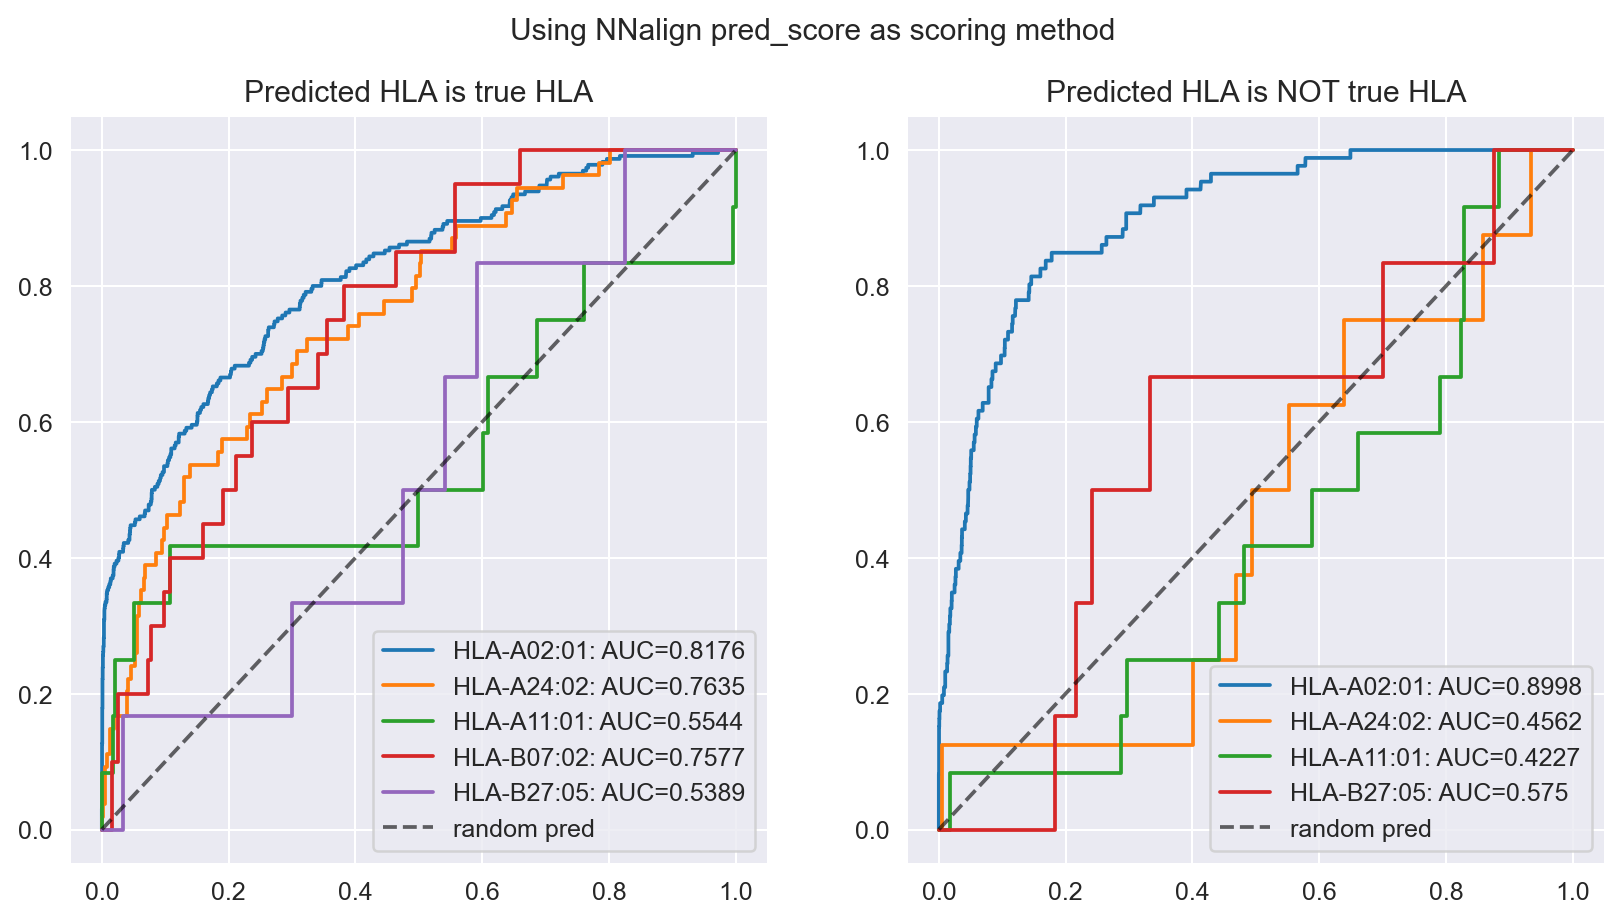

In [13]:
top10_hla = cedar_hp_core.groupby(['HLA'])[['Peptide']].count().sort_values('Peptide',ascending=False).head(10).index
top5_hla = cedar_hp_core.groupby(['HLA'])[['Peptide']].count().sort_values('Peptide',ascending=False).head(5).index

f,a = plt.subplots(1,2, figsize=(11, 5.5))

scoring='Prediction'
for hla in top5_hla:
    tmp = cedar_hp_core.query('HLA==@hla')
    negs = tmp.query('agg_label==0')
    if len(negs)==0:
        continue
    for true_hla,axis in zip([True, False], [0,1]):
        pos = tmp.query('agg_label==1')
        pos = pos.loc[pos['HLA']==pos['pred_HLA']] if true_hla else pos.loc[pos['HLA']!=pos['pred_HLA']]
        if len(pos)==0:
            break
        tmp_1 = pd.concat([pos, negs])
        y_true = tmp_1['agg_label'].values
        scores = tmp_1[scoring].values
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)
        sns.lineplot(x=fpr, y=tpr, label = f'{hla}: AUC={auc.round(4)}', ax = a[axis], estimator = None)
        name = 'Predicted HLA is true HLA' if true_hla else 'Predicted HLA is NOT true HLA'
        a[axis].set_title(name)
f.suptitle('Using NNalign pred_score as scoring method')
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[0])
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[1])

## Cedar ranks checks

In [14]:
print(f"Percentage of correctly predicted HLA: {(len(cedar_all.loc[cedar_all['HLA']==cedar_all['pred_HLA']])/len(cedar_all)):.3%}")

Percentage of correctly predicted HLA: 48.607%


Text(0.5, 1.0, 'CEDAR EL_rank distributions for Pos vs Neg')

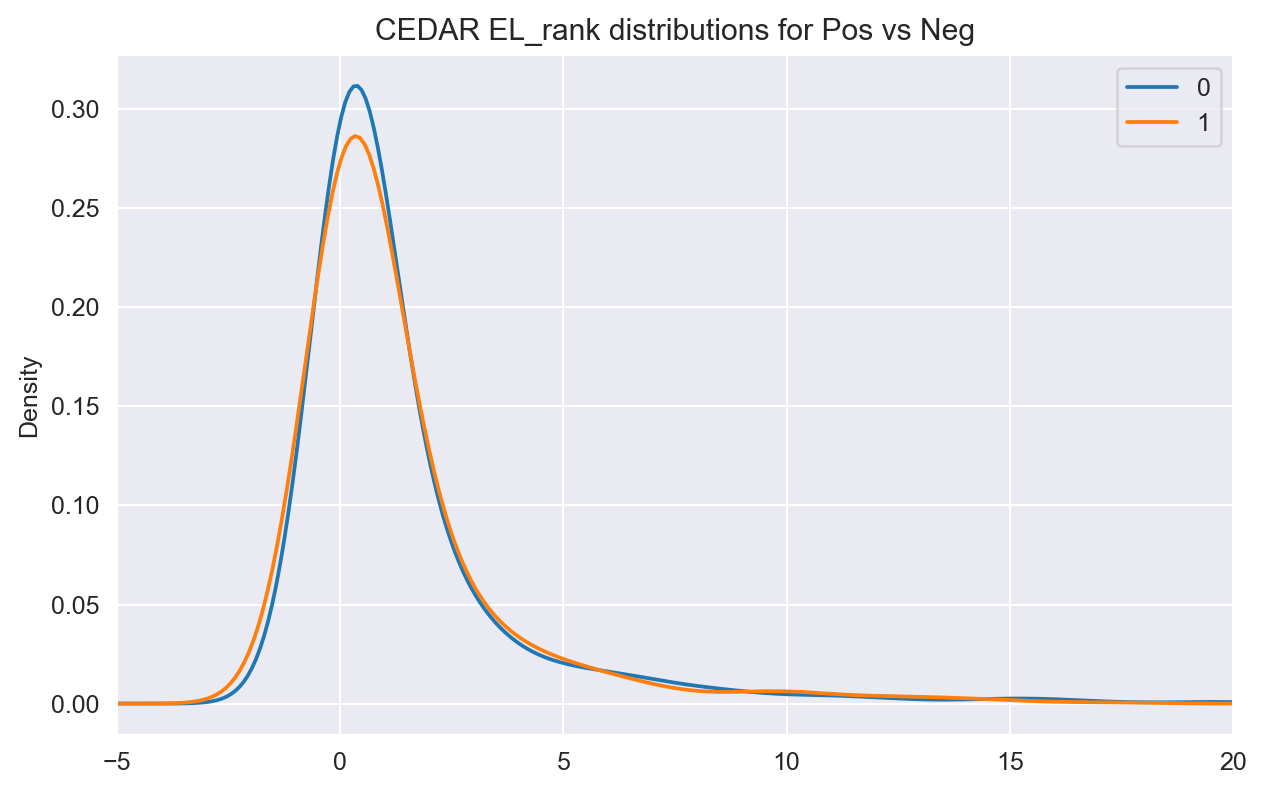

In [15]:
f,a=plt.subplots(figsize=(8,5))
cedar_all.groupby('agg_label')['EL_rank'].plot(kind='kde', legend=True)
a.set_xlim([-5,20])
a.set_title('CEDAR EL_rank distributions for Pos vs Neg')

# Old CEDAR refiltering on alignment core file ("comparing apples to apples")

## reloading data and scores

In [64]:
cedar_posneg_hp_peps = results['cedar_posneg_hp']['df'].query('dataset=="hp"').Peptide.values
negatives_from_hpnegs = pd.concat([pd.concat([pd.read_csv(f'../output/9mers_humanproteome_chunk_{x}scored.txt').query('Peptide in @cedar_posneg_hp_peps') for x in [0, 1, 2, 3]]),
                                  pd.concat([pd.read_csv(f'../output/10mers_humanproteome_chunk_{x}scored.txt').query('Peptide in @cedar_posneg_hp_peps') for x in [0, 1, 2, 3]]),
                                  pd.concat([pd.read_csv(f'../output/8mers_humanproteome_chunk_{x}scored.txt').query('Peptide in @cedar_posneg_hp_peps') for x in [0, 1, 2, 3]]),
                                  pd.concat([pd.read_csv(f'../output/11mers_humanproteome_chunk_{x}scored.txt').query('Peptide in @cedar_posneg_hp_peps') for x in [0, 1, 2, 3]])])
negatives_from_hpnegs['agg_label']=0
negatives_from_hpnegs['pred_HLA'] = negatives_from_hpnegs['HLA']
negatives_from_hpnegs.columns = negatives_from_hpnegs.columns.str.replace('Rank','rank')

In [69]:
negatives_from_hpnegs[['total_count', 'percentage_pos', 'dataset']] = 1, 0, 'hp'
negatives_from_hpnegs['len'] = negatives_from_hpnegs['Peptide'].apply(len)

In [85]:
results[k]['core'].columns.difference(cedar_hp_scores.columns)
results[k]['core'].columns

Index(['Peptide', 'HLA', 'Core', 'P1', 'Measure', 'Prediction', 'Gap_pos',
       'Gap_lgt', 'Insert_pos', 'Insert_lgt', 'Core+gap', 'P1_Rel'],
      dtype='object')

In [86]:
score_cols = ['Peptide', 'HLA', 'agg_label', 'total_count', 'percentage_pos', 'len', 'pred_HLA', 'EL_rank', 'BA_rank', 'dataset']
cedar_hp_scores = pd.concat([pd.read_csv('../data/cedar_hp_hohobm_scored.csv'), 
                             pd.read_csv('../data/cedar_netmhc_scored.csv').assign(dataset='cedar'),
                            negatives_from_hpnegs])[score_cols].drop_duplicates()
# Rescoring
keys = ['cedar', 'cedar_refined', 'cedar_posneg_hp']
for k in keys:
    results[k]['core_scored'] = pd.merge(results[k]['core'][['Peptide', 'Prediction', 'Measure']], 
                                         cedar_hp_scores, left_on='Peptide', right_on='Peptide')
    print(len(results[k]['core_scored']))

1687
777
3734


## Comparing : Querying Refined, vs Cedar & Cedar_posneg_hp

Text(0.5, 0.98, 'Comparison of AUC for different dataset queried refined_negss, with different scoring methods & true/pred HLA')

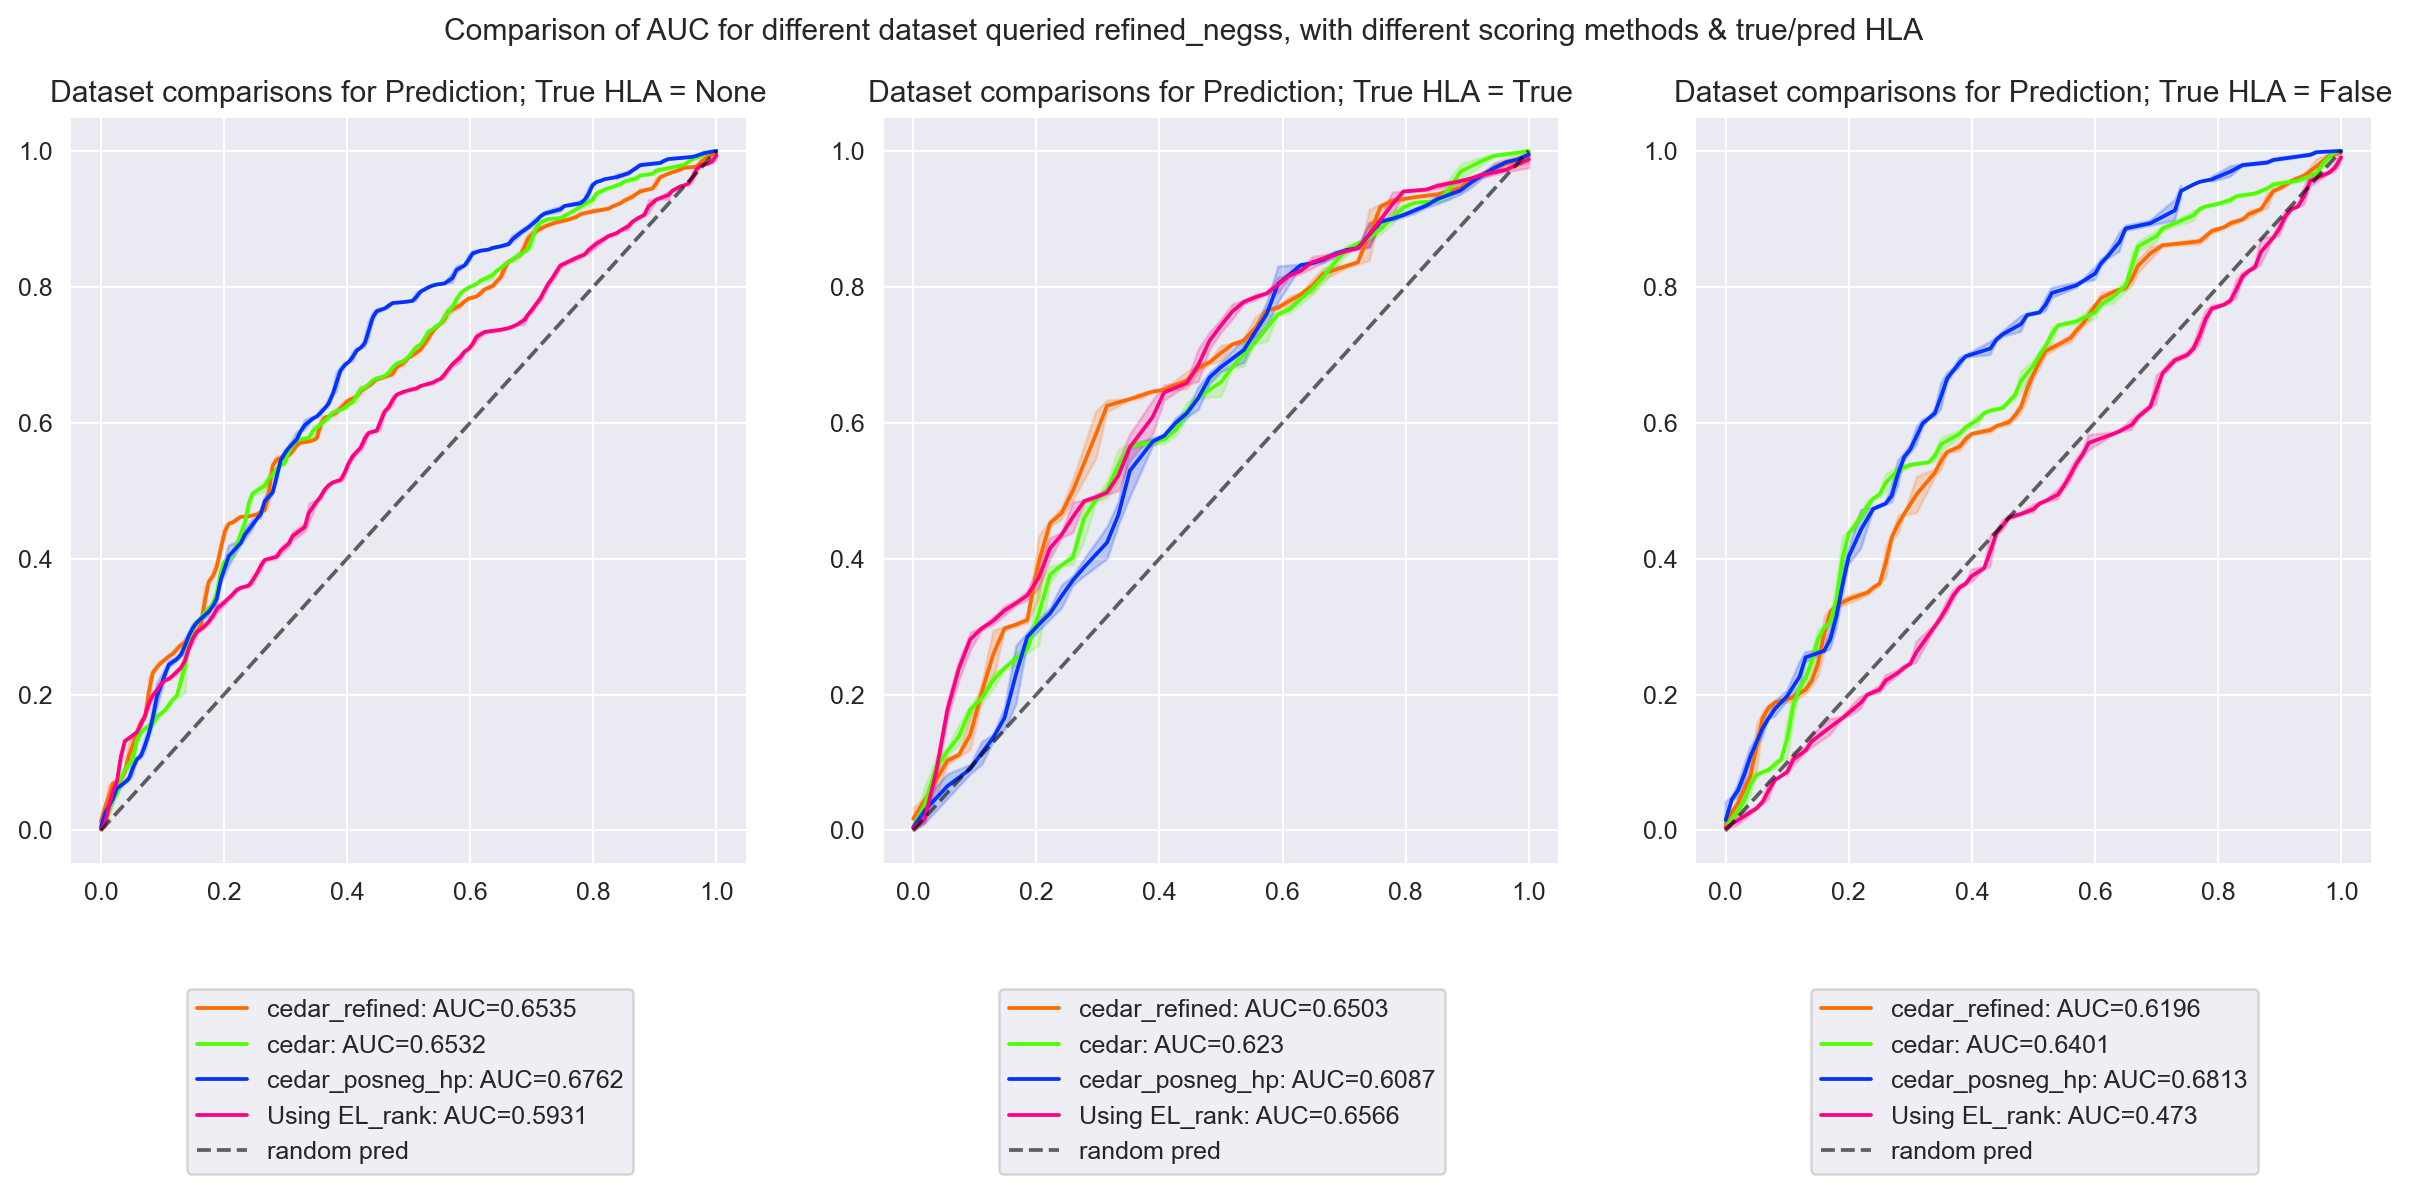

In [150]:
f,a = plt.subplots(1,3, figsize=(16.5, 5.5))
sns.set_palette(n4)
axis=0
a = a.ravel()
pep_query = results['cedar_refined']['core'].Peptide.unique()
for scoring in ['Prediction']:
    for true_hla in [None, True, False]:
        for k in ['cedar_refined', 'cedar', 'cedar_posneg_hp']:
            tmp = results[k]['core_scored'].query('Peptide in @pep_query')
            if true_hla is not None:
                tmp = tmp.loc[tmp['HLA']==tmp['pred_HLA']] if true_hla else tmp.loc[tmp['HLA']!=tmp['pred_HLA']]
    
            y_true = tmp['agg_label'].values
            scores = tmp[scoring].values
            fpr, tpr, _ = roc_curve(y_true, scores)
            auc = roc_auc_score(y_true, scores)
            sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc.round(4)}', ax = a[axis], n_boot=500, palette=n4)
        
        # Adding EL_rank 
        scores=tmp['EL_rank']*-1
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)
        sns.lineplot(x=fpr, y=tpr, label = f'Using EL_rank: AUC={auc.round(4)}', ax = a[axis], n_boot=500, palette=n4)
        
        sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[axis])
        a[axis].set_title(f'Dataset comparisons for {scoring}; True HLA = {true_hla}')
        a[axis].legend(bbox_to_anchor=(.85, -.15))
        axis+=1
    
f.suptitle('Comparison of AUC for different dataset queried refined_negss, with different scoring methods & true/pred HLA')


## Querying Cedar only, comparing Cedar_posneg_hp and cedar

Text(0.5, 0.98, 'Comparison of AUC for different dataset queried on the same peptides, with different scoring methods & true/pred HLA')

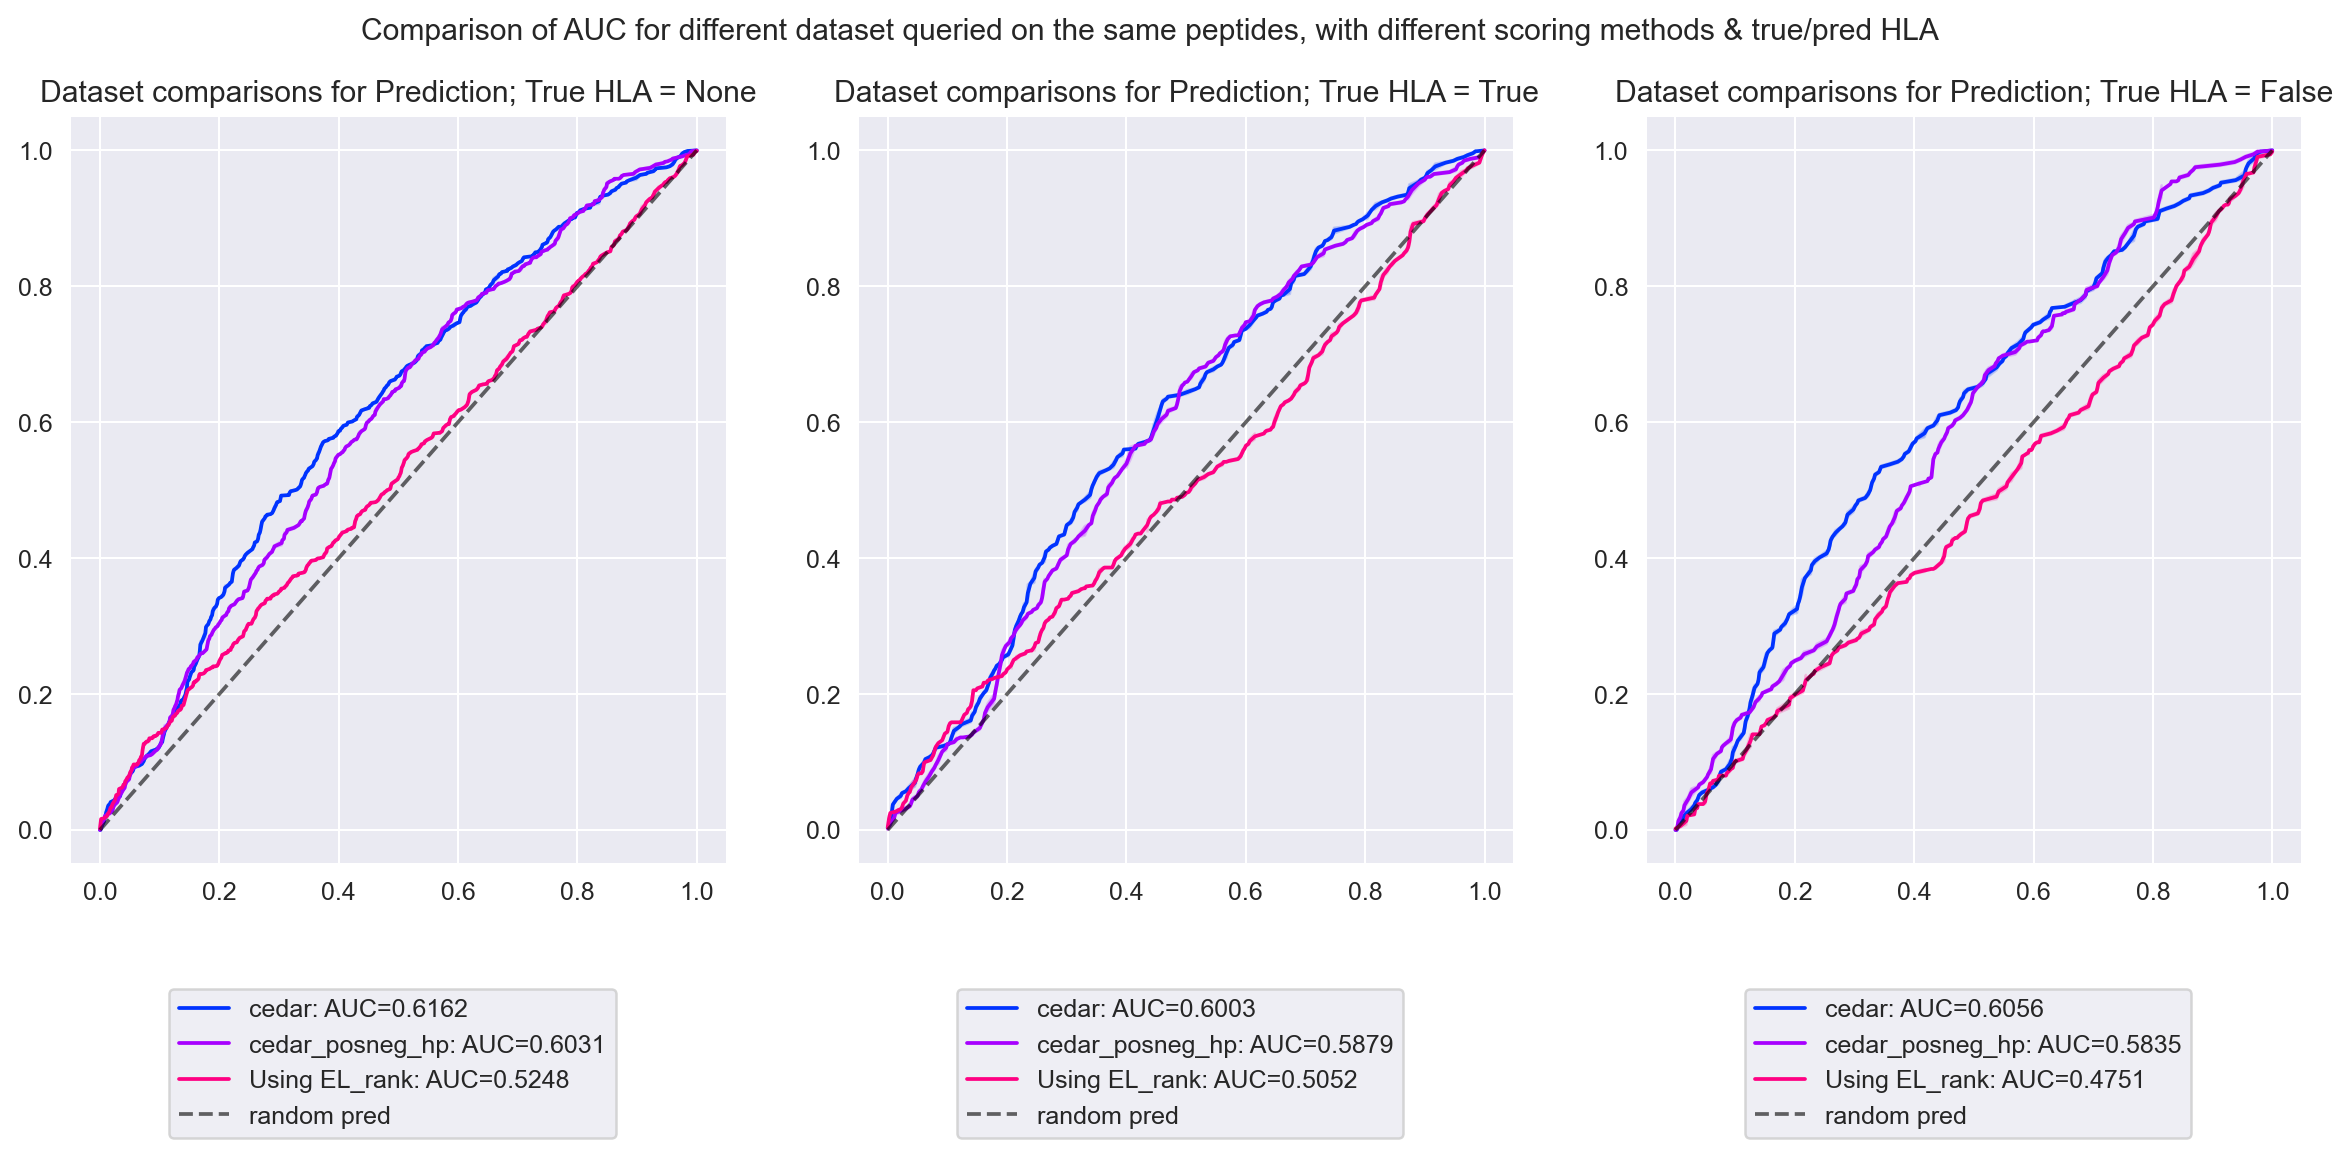

In [153]:
f,a = plt.subplots(1,3, figsize=(16,5.5))
keys = ['cedar', 'cedar_posneg_hp']
pep_query = results['cedar']['core'].Peptide.unique()
sns.set_palette(n3, n_colors=3)
axis=0
for scoring in ['Prediction']:
    for true_hla in [None, True, False]:
        for k in ['cedar', 'cedar_posneg_hp']:
            tmp = results[k]['core_scored'].query('Peptide in @pep_query')
            if true_hla is not None:
                tmp = tmp.loc[tmp['HLA']==tmp['pred_HLA']] if true_hla else tmp.loc[tmp['HLA']!=tmp['pred_HLA']]
    
            y_true = tmp['agg_label'].values
            scores = tmp[scoring].values
            fpr, tpr, _ = roc_curve(y_true, scores)
            auc = roc_auc_score(y_true, scores)
            sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc.round(4)}', ax = a[axis], n_boot=500, palette=n3)
        
        # Adding EL_rank 
        scores=tmp['EL_rank']*-1
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)
        sns.lineplot(x=fpr, y=tpr, label = f'Using EL_rank: AUC={auc.round(4)}', ax = a[axis], n_boot=500, palette=n3)
        
        sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[axis])
        a[axis].set_title(f'Dataset comparisons for {scoring}; True HLA = {true_hla}')
        a[axis].legend(bbox_to_anchor=(.85, -.15))
        axis+=1
    
f.suptitle('Comparison of AUC for different dataset queried on the same peptides, with different scoring methods & true/pred HLA')


# New Cedar datadump 

In [16]:
# exporting to score the hlas for the new datasets
pd.read_csv('../data/cedar_neoepitope_220701.csv')['Peptide'].to_csv('../data/cedar_neoepitope_220701.pep', index=False,header=None)
pd.read_csv('../data/cedar_neoepi_hpneg.csv')['Peptide'].to_csv('../data/cedar_neoepi_hpneg.pep', index=False,header=None)
hlas_to_score=','.join(['HLA-A02:06','HLA-B15:01','HLA-A02:01','HLA-A03:01','HLA-A11:01', 'HLA-B07:02','HLA-A24:02','HLA-A01:01','HLA-B35:01','HLA-B40:01','HLA-B08:01','HLA-B27:05'])
hlas_to_score

'HLA-A02:06,HLA-B15:01,HLA-A02:01,HLA-A03:01,HLA-A11:01,HLA-B07:02,HLA-A24:02,HLA-A01:01,HLA-B35:01,HLA-B40:01,HLA-B08:01,HLA-B27:05'

## reloading new stuff

In [17]:
### FIRST DATASET:
# rereading only cedar + scored netmhcpan output
df_cedar_neoepi = pd.read_csv('../data/cedar_neoepitope_220701.csv').query('len>=8 and len<=14').drop(columns = ['Unnamed: 0']).reset_index(drop=True)
prime_cedarneoepi = pd.read_csv('../../../gfeller_tools/PRIME/output/cedar_neoepi_220701_prime_out.txt',
                                sep='\t', comment='#')
# Reading the alignment core output
nnalign_cedarneoepi = pd.read_csv('../../../nnalign/output/neo_epi_220701.pep_18784/neo_epi_220701.pep_18784.lg6.sorted.pred',
                                 sep='\t')

xxxx = df_cedar_neoepi.Peptide.unique()
# rereading netmhcpan output & scoring£
df_cedar_neoepi_xls = read_netmhcpan_results('./cedar_neoepitope_220701.xls')
df_cedar_neoepi_xls = df_cedar_neoepi_xls.query('@df_cedar_neoepi_xls.base.Peptide in @xxxx').reset_index(drop=True)
df_cedar_neoepi_xls = get_filtered_df(filter_rank(df_cedar_neoepi_xls, 'EL_Rank'), df_cedar_neoepi_xls)
df_cedar_neoepi = pd.merge(left=df_cedar_neoepi, right=df_cedar_neoepi_xls.rename(columns={'HLA':'pred_HLA'}), left_index=True, right_index=True)
df_cedar_neoepi['HLA']= df_cedar_neoepi['HLA'].str.replace('*','')
# Merging to prime results
prime_neoepi_new = pd.merge(df_cedar_neoepi, prime_cedarneoepi, left_on='Peptide', right_on='Peptide')


### SECOND DATASET: 
# neoepi_hp = new cedar pos + hp negs, no cedar negs
df_neoepi_hp = pd.read_csv('../data/cedar_neoepi_hpneg.csv')
prime_neoepi_hp = pd.read_csv('../../../gfeller_tools/PRIME/output/cedar_neoepi_hpneg.txt', 
                              sep='\t', comment='#')
nnalign_hpneoepi = pd.read_csv('../../../nnalign/output/cedar_neoepi_hpneg.pep_9121/cedar_neoepi_hpneg.pep_9121.lg6.sorted.pred',
                               sep='\t')

df_neoepi_hp_xls = read_netmhcpan_results('./cedar_neoepi_hpneg.xls')
df_neoepi_hp_xls = get_filtered_df(filter_rank(df_neoepi_hp_xls, 'EL_Rank'), df_neoepi_hp_xls)
df_neoepi_hp = pd.merge(left=df_neoepi_hp, right=df_neoepi_hp_xls.rename(columns={'HLA':'pred_HLA'}), left_index=True, right_index=True)
df_neoepi_hp['HLA']= df_neoepi_hp['HLA'].str.replace('*','')

# Nmerging to prime results
prime_mixed_new = pd.merge(df_neoepi_hp, prime_neoepi_hp, left_on='Peptide', right_on='Peptide')

## Reloading old PRIME results

### old mixed (cedar pos + hp negs)

In [18]:
negatives_from_hpnegs = pd.concat([pd.concat([pd.read_csv(f'../output/9mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]]),
                                  pd.concat([pd.read_csv(f'../output/10mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]]),
                                  pd.concat([pd.read_csv(f'../output/8mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]]),
                                  pd.concat([pd.read_csv(f'../output/11mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])])
negatives_from_hpnegs['agg_label']=0
negatives_from_hpnegs['pred_HLA'] = negatives_from_hpnegs['HLA']
negatives_from_hpnegs.columns = negatives_from_hpnegs.columns.str.replace('Rank','rank')

In [19]:
mixed_prime = pd.read_csv('./cedar_pos_hpneg_results.txt', comment='#', sep='\t', usecols=range(5))
mixed_prime['len'] = mixed_prime['Peptide'].apply(len)
mixed_tmp = mixed_prime.Peptide.unique()

neg_mixed = negatives_from_hpnegs.query('Peptide in @mixed_tmp')
pos_mixed = cedar_all.query('Peptide in @mixed_tmp')
common_cols = negatives_from_hpnegs.columns.join(pos_mixed.columns,how='inner')
neg_mixed['len'] = neg_mixed['Peptide'].apply(len)
pos_mixed['len'] = pos_mixed['Peptide'].apply(len)
mixed = pd.concat([pos_mixed[common_cols], neg_mixed[common_cols]], ignore_index=True)
prime_mixed_old = pd.merge(mixed, mixed_prime, left_on='Peptide', right_on='Peptide')
del negatives_from_hpnegs, mixed, mixed_prime

### old all (cedar only, selecting ELIS and collapsing duplicates, no refined filtering on negs)

In [20]:
prime_cedar_old = pd.merge(cedar_all, pd.read_csv('./PRIME_cedar_filtered_results.txt', comment = '#', sep = '\t'), 
                       left_on = 'Peptide', right_on = 'Peptide')

## PRIME comparison 

In [21]:
prime_cedar_old['kind'] = 'cedar_old'
prime_neoepi_new['kind'] = 'neoepi_new'
prime_mixed_old['kind'] = 'mixed_old'
prime_mixed_new['kind'] = 'mixed_new'

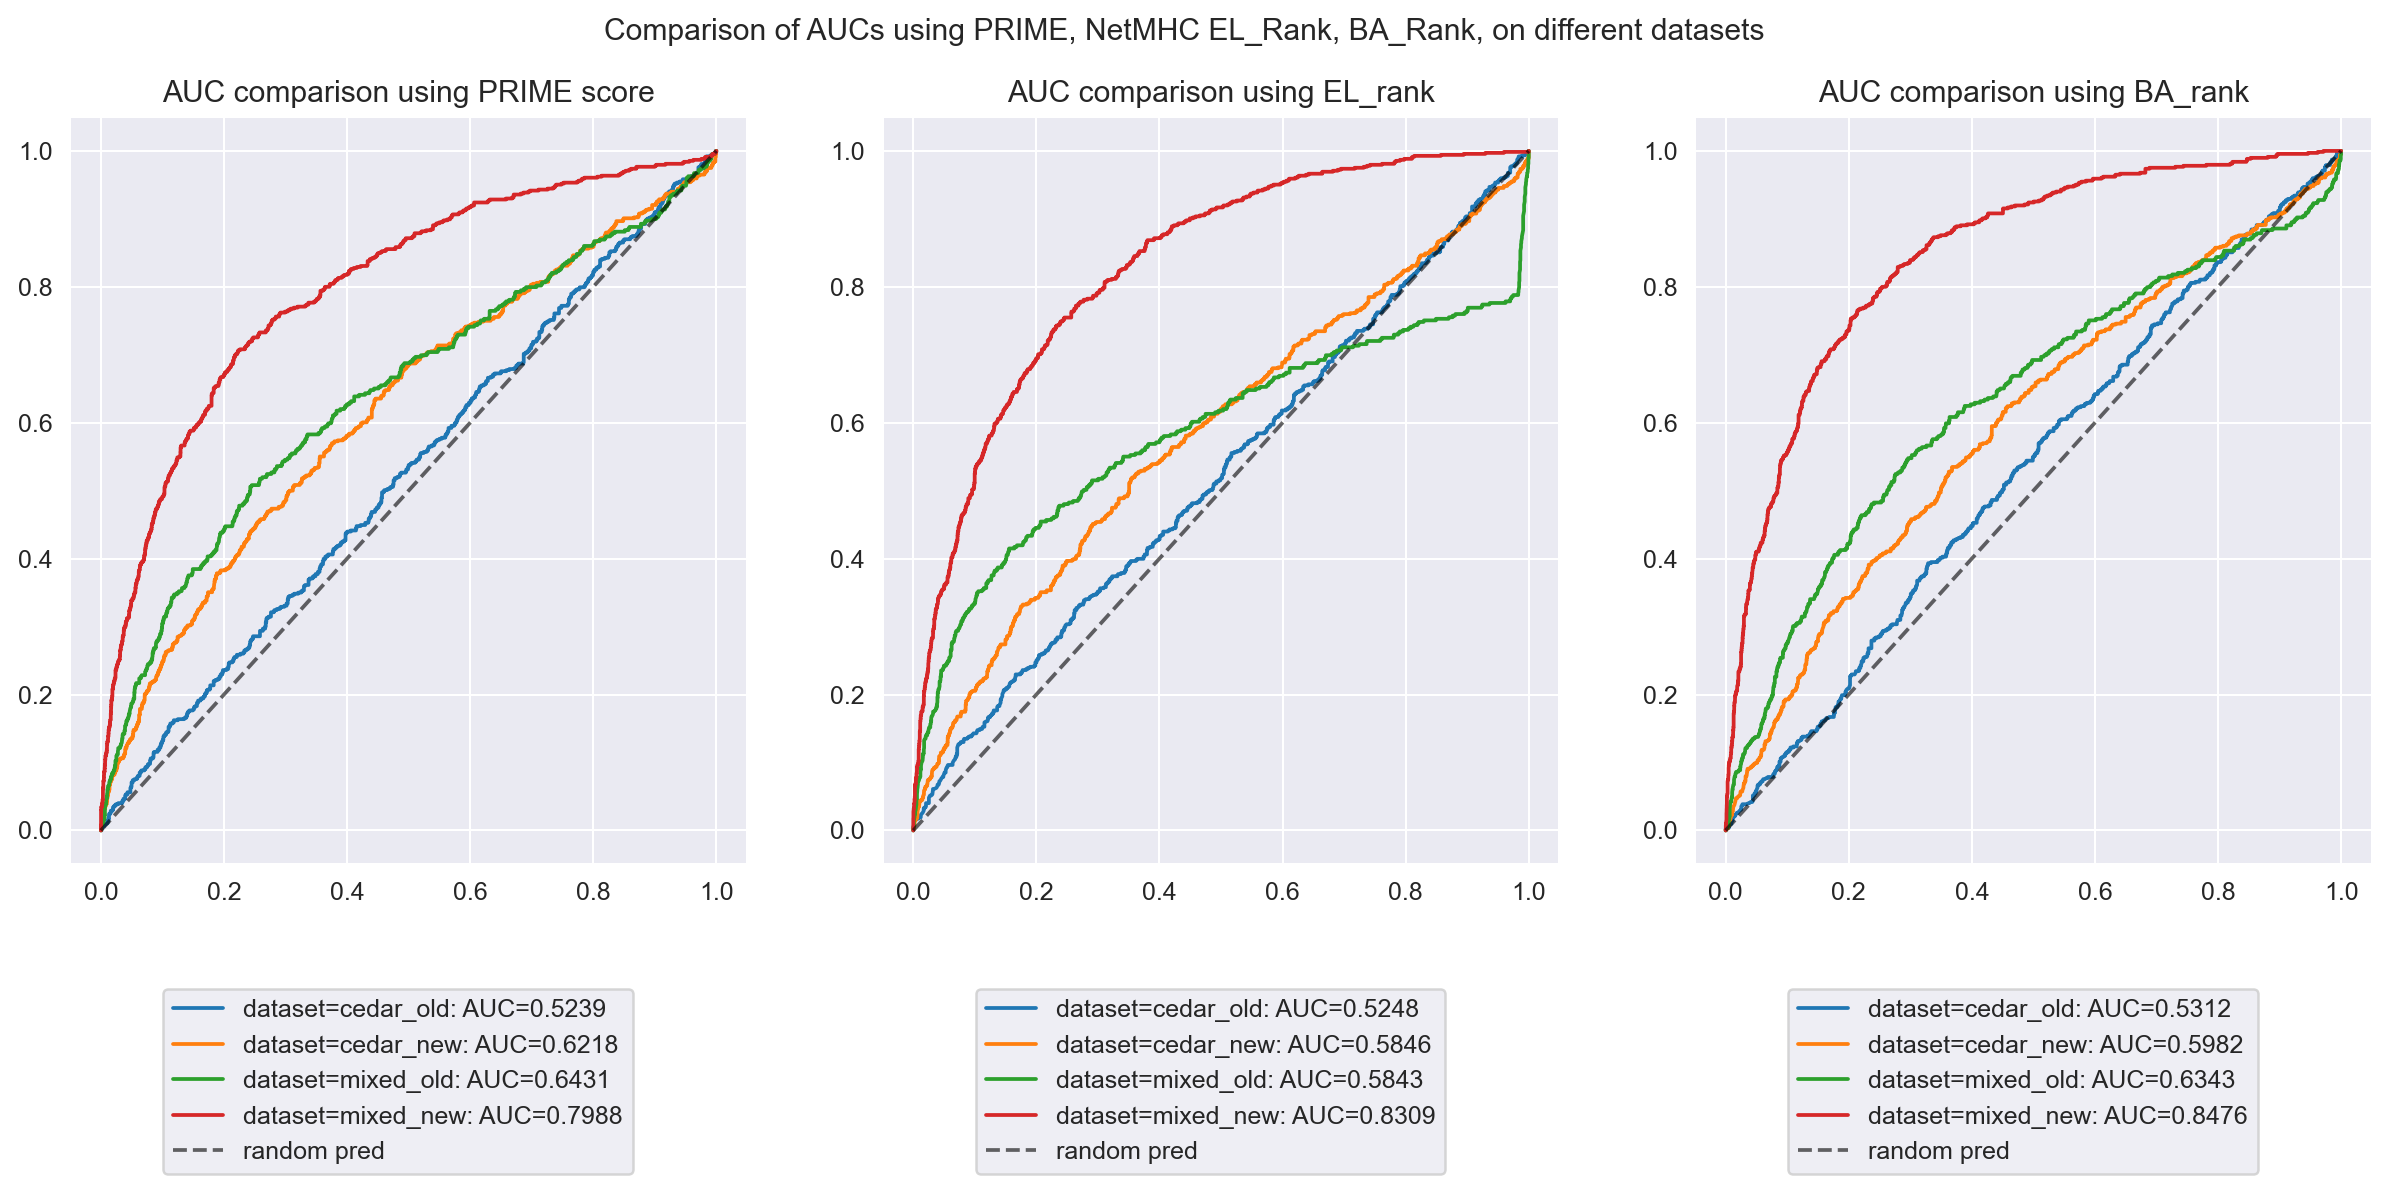

In [22]:
prime_results = {'cedar_old':prime_cedar_old,
                 'cedar_new':prime_neoepi_new,
                 'mixed_old':prime_mixed_old,
                 'mixed_new':prime_mixed_new}

f,a = plt.subplots(1,3, figsize=(16.5,5.5))
axis=0
for scoring in ['Score_bestAllele', 'EL_rank', 'BA_rank']:
    name = 'PRIME score' if scoring=='Score_bestAllele' else scoring
    a[axis].set_title(f'AUC comparison using {name}')
    sign = 1 if scoring=='Score_bestAllele' else -1
    for k,v in prime_results.items():
        tmp = v.copy()
        y_true = tmp['agg_label'].values
        scores = tmp[scoring].values * sign
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)
        
        sns.lineplot(x=fpr, y=tpr, label = f'dataset={k}: AUC={auc.round(4)}', ax = a[axis], estimator = None)
                
    sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[axis])
    a[axis].legend(bbox_to_anchor=(.85, -.15))
    f.suptitle('Comparison of AUCs using PRIME, NetMHC EL_Rank, BA_Rank, on different datasets')
    axis+=1

## PRIME and nnalign core comparison

### reloading stupid el ranks from hp

In [23]:
from tqdm.auto import tqdm
# Re-get the stupid EL ranks from the scored file in human proteome
peps=results['cedar_posneg_hp']['df'].query('dataset=="hp"').Peptide.unique()
xddd =[]
for x in tqdm([x for x in os.listdir('../output/') if 'scored' in x]):
    tmp = pd.read_csv(f'../output/{x}').query('Peptide in @peps')
    xddd.append(tmp)
scored_hp_negs=pd.concat(xddd)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:51<00:00,  2.58s/it]


In [24]:
scored_hp_negs.columns = scored_hp_negs.columns.str.replace('Rank','rank')
scored_hp_negs[['agg_label', 'total_count', 'percentage_pos', 'dataset']] = 0, 1, 0,'hp'
scored_hp_negs['len'] = scored_hp_negs['Peptide'].apply(len)
scored_hp_negs['pred_HLA'] =  scored_hp_negs['HLA']

for k in results.keys():
    if 'new' not in k:
        results[k]['core']=results[k]['core'].merge(cedar_hp_scores, left_on='Peptide', right_on='Peptide')   
    

NameError: name 'cedar_hp_scores' is not defined

### nnalign pred vs elrank

In [ ]:

core_neoepi = pd.merge(df_cedar_neoepi, nnalign_cedarneoepi, left_on='Peptide', right_on='Peptide')
core_neoepi_hp = pd.merge(df_neoepi_hp, nnalign_hpneoepi, left_on='Peptide', right_on='Peptide')

results['neoepi_new'] = {}
results['neoepi_hp_new'] = {}
results['neoepi_new']['core'] = core_neoepi
results['neoepi_hp_new']['core'] = core_neoepi_hp

f,a = plt.subplots(1,2, figsize=(11,5.5))
axis=0
for scoring in ['Prediction', 'EL_rank']:
    sign = 1 if scoring=='Prediction' else -1
    for k in results.keys():
        y_true = results[k]['core']['agg_label'].values.astype(int)
        y_score = results[k]['core'][scoring].values * sign
        fpr,tpr,thresholds=roc_curve(y_true, y_score, pos_label=1.0)
        results[k]['fpr'] = fpr
        results[k]['tpr'] = tpr
        results[k]['auc'] = roc_auc_score(y_true, y_score)
        sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={results[k]["auc"].round(4)}', estimator=None, ax=a[axis])
    sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[axis])
    a[axis].set_title(f'Dataset comparison using scoring={scoring}')
    a[axis].legend(bbox_to_anchor=(.75, -.15))
    axis+=1

In [ ]:
# results['cedar_hp_hobohm']['core'].drop(columns=['HLA_y'], inplace=True)
results['cedar_hp_hobohm']['core'].rename(columns={'HLA_x':'HLA'}, inplace=True)

In [ ]:
results['cedar_hp_hobohm']['core'].columns

In [ ]:
results['cedar_hp_hobohm']['core'][['Peptide', 'HLA', 'agg_label', 'total_count', 
                                    'percentage_pos', 'len', 'pred_HLA',
                                    'EL_rank', 'BA_rank', 'dataset']].to_csv('../data/cedar_hp_hohobm_scored.csv',
                                                                            index=False)

In [ ]:
results['neoepi_hp_new']['core'][['Peptide', 'HLA', 'agg_label', 'total_count', 
                                    'percentage_pos', 'len', 'pred_HLA',
                                    'EL_rank', 'BA_rank', 'dataset']].to_csv('../data/neoepi_hp_hobohm_scored.csv', index=False)